# Price Modeling by Product with XGBoost and LightGBM

This notebook trains separate models by product (`Gasoline`, `Ethanol`, `Diesel`) to predict `avg_preco_venda`, using XGBoost and LightGBM with hyperparameter tuning.


In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

df = pd.read_parquet("./../data/02_silver/oil_and_gas_dataset-focused_columns.parquet")
# df deve conter: data, avg_preco_venda, avg_preco_compra, produto, bandeira_revenda_cat, n_estabelecimentos
df["data"] = pd.to_datetime(df["data"])
df["month"] = df["data"].dt.to_period("M").dt.to_timestamp()

# Winsorize avg_preco_compra
df["price_spread"] = df["avg_preco_venda"] - df["winsor_preco_compra"]

# Rolling média de 3 meses
df = df.sort_values("data")
df["rolling_avg_venda_3m"] = df.groupby("produto")["avg_preco_venda"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Volatilidade mensal
vol = df.groupby(["month", "produto"])["avg_preco_venda"].std().reset_index().rename(columns={"avg_preco_venda": "monthly_volatility"})
df = df.merge(vol, on=["month", "produto"], how="left")

# Ensure proper sorting
df = df.sort_values(['produto', 'data'])

# Create lagged features (you can add more lags if needed)
for lag in [1, 2, 3]:
    df[f'lag_venda_{lag}'] = df.groupby('produto')['avg_preco_venda'].shift(lag)
    df[f'lag_compra_{lag}'] = df.groupby('produto')['avg_preco_compra'].shift(lag)

df_lagged = df.dropna(subset=[f'lag_venda_{i}' for i in [1, 2, 3]] + [f'lag_compra_{i}' for i in [1, 2, 3]])
# Log transform
df["log_n_estabelecimentos"] = np.log1p(df["n_estabelecimentos"])

df_model = df.dropna(subset=['avg_preco_venda'])
df_model = df_model.drop(columns=['sigla_uf','id_municipio','faixa_estabelecimentos','n_estabelecimentos','avg_preco_compra','data'], axis=1)


In [4]:
df_model.columns

Index(['bandeira_revenda_cat', 'produto', 'avg_preco_venda',
       'winsor_preco_compra', 'log_n_estabelecimentos', 'month',
       'price_spread', 'rolling_avg_venda_3m', 'monthly_volatility',
       'lag_venda_1', 'lag_compra_1', 'lag_venda_2', 'lag_compra_2',
       'lag_venda_3', 'lag_compra_3'],
      dtype='object')

In [5]:

features = [
    'lag_venda_1', 'lag_venda_2', 'lag_venda_3',
    'lag_compra_1', 'lag_compra_2', 'lag_compra_3',
    'log_n_estabelecimentos',
    'bandeira_revenda_cat','price_spread', 'rolling_avg_venda_3m', 'monthly_volatility',
    'winsor_preco_compra'
]

target = 'avg_preco_venda'
categorical = ['bandeira_revenda_cat']

def avaliar_modelo(modelo, X_test, y_test, y_pred, nome_modelo):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{nome_modelo} — MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return mae, rmse, r2


In [6]:

resultados = []

for prod in df_model['produto'].unique():
    print(f"\n🔹 Produto: {prod}")
    df_prod = df_model[df_model['produto'] == prod].copy()
    df_prod = df_prod.sort_values('month')
    print(df_prod.columns)
    print(features)
    print(categorical)


    X = df_prod[features]
    y = df_prod[target]

    tscv = TimeSeriesSplit(n_splits=5)

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ], remainder='passthrough')

    # LightGBM
    pipeline_lgb = Pipeline([
        ('preprocess', preprocessor),
        ('model', LGBMRegressor())
    ])

    param_grid_lgb = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1]
    }

    gs_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    gs_lgb.fit(X, y)
    best_lgb = gs_lgb.best_estimator_

    # XGBoost
    pipeline_xgb = Pipeline([
        ('preprocess', preprocessor),
        ('model', XGBRegressor(objective='reg:squarederror'))
    ])

    param_grid_xgb = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1]
    }

    gs_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    gs_xgb.fit(X, y)
    best_xgb = gs_xgb.best_estimator_

    # Avaliação
    X_test = X.iloc[-3:]
    y_test = y.iloc[-3:]
    y_pred_lgb = best_lgb.predict(X_test)
    y_pred_xgb = best_xgb.predict(X_test)

    resultados.append({
        'Produto': prod,
        'Modelo': 'LightGBM',
        **dict(zip(['MAE', 'RMSE', 'R2'], avaliar_modelo(best_lgb, X_test, y_test, y_pred_lgb, 'LightGBM')))
    })
    resultados.append({
        'Produto': prod,
        'Modelo': 'XGBoost',
        **dict(zip(['MAE', 'RMSE', 'R2'], avaliar_modelo(best_xgb, X_test, y_test, y_pred_xgb, 'XGBoost')))
    })



🔹 Produto: Diesel
Index(['bandeira_revenda_cat', 'produto', 'avg_preco_venda',
       'winsor_preco_compra', 'log_n_estabelecimentos', 'month',
       'price_spread', 'rolling_avg_venda_3m', 'monthly_volatility',
       'lag_venda_1', 'lag_compra_1', 'lag_venda_2', 'lag_compra_2',
       'lag_venda_3', 'lag_compra_3'],
      dtype='object')
['lag_venda_1', 'lag_venda_2', 'lag_venda_3', 'lag_compra_1', 'lag_compra_2', 'lag_compra_3', 'log_n_estabelecimentos', 'bandeira_revenda_cat', 'price_spread', 'rolling_avg_venda_3m', 'monthly_volatility', 'winsor_preco_compra']
['bandeira_revenda_cat']


c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2600
[LightGBM] [Info] Number of data points in the train set: 175880, number of used features: 15
[LightGBM] [Info] Start training from score 3.160084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM — MAE: 0.0111, RMSE: 0.0118, R²: 0.9946
XGBoost — MAE: 0.0095, RMSE: 0.0102, R²: 0.9960

🔹 Produto: Etanol
Index(['bandeira_revenda_cat', 'produto', 'avg_preco_venda',
       'winsor_preco_compra', 'log_n_estabelecimentos', 'month',
       'price_spread', 'rolling_avg_venda_3m', 'monthly_volatility',
       'lag_venda_1', 'lag_compra_1', 'lag_venda_2', 'lag_compra_2',
       'lag_venda_3', 'lag_compra_3'],
      dtype='object')
['lag_venda_1', 'lag_venda_2', 'lag_venda_3', 'lag_compra_1', 'lag_compra_2', 'lag_compra_3', 'log_n_estabelecimentos', 'bandeira_revenda_cat', 'price_spread', 'rolling_avg_venda_3m', 'monthly_volatility', 'winsor_preco_compra']
['bandeira_revenda_cat']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 185910, number of used features: 15
[LightGBM] [Inf

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM — MAE: 0.0058, RMSE: 0.0070, R²: 0.9995
XGBoost — MAE: 0.0064, RMSE: 0.0075, R²: 0.9994

🔹 Produto: Gasolina
Index(['bandeira_revenda_cat', 'produto', 'avg_preco_venda',
       'winsor_preco_compra', 'log_n_estabelecimentos', 'month',
       'price_spread', 'rolling_avg_venda_3m', 'monthly_volatility',
       'lag_venda_1', 'lag_compra_1', 'lag_venda_2', 'lag_compra_2',
       'lag_venda_3', 'lag_compra_3'],
      dtype='object')
['lag_venda_1', 'lag_venda_2', 'lag_venda_3', 'lag_compra_1', 'lag_compra_2', 'lag_compra_3', 'log_n_estabelecimentos', 'bandeira_revenda_cat', 'price_spread', 'rolling_avg_venda_3m', 'monthly_volatility', 'winsor_preco_compra']
['bandeira_revenda_cat']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 194711, number of used features: 15
[LightGBM] [I

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [7]:
resultados = []

# Garante que a coluna 'month' está em datetime
df_model['month'] = pd.to_datetime(df_model['month'])
# Agregação por mês e produto
df_model = df_model.groupby(['month', 'produto']).agg({
    'avg_preco_venda': 'mean',
    'lag_venda_1': 'mean',
    'lag_venda_2': 'mean',
    'lag_venda_3': 'mean',
    'lag_compra_1': 'mean',
    'lag_compra_2': 'mean',
    'lag_compra_3': 'mean',
    'log_n_estabelecimentos': 'mean',
    'winsor_preco_compra': 'mean',
    'bandeira_revenda_cat': 'first',
    'price_spread': "mean", 
    'rolling_avg_venda_3m': "mean", 
    'monthly_volatility': "mean",
}).reset_index()

# Define datas futuras específicas
meses_futuros = pd.to_datetime(["2024-06-01", "2024-07-01", "2024-08-01"])

for prod in df_model['produto'].dropna().unique():
    print(f"\n🔹 Produto: {prod}")
    df_prod = df_model[df_model['produto'] == prod].copy()
    df_prod = df_prod.sort_values('month')

    # Divide treino e futuro
    df_treino = df_prod[df_prod['month'] < "2024-06-01"]
    df_futuro = df_prod[df_prod['month'].isin(meses_futuros)]

    # Garante que todas as features estão disponíveis
    missing_cols = [col for col in features if col not in df_treino.columns]
    if missing_cols:
        print(f"⚠️ Colunas ausentes para {prod}: {missing_cols}. Pulando...")
        continue

    X_train = df_treino[features]
    y_train = df_treino[target]
    X_test = df_futuro[features]
    y_test = df_futuro[target]

    tscv = TimeSeriesSplit(n_splits=5)

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ], remainder='passthrough')

    # LightGBM
    pipeline_lgb = Pipeline([
        ('preprocess', preprocessor),
        ('model', LGBMRegressor())
    ])

    param_grid_lgb = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1]
    }

    gs_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    gs_lgb.fit(X_train, y_train)
    best_lgb = gs_lgb.best_estimator_

    # XGBoost
    pipeline_xgb = Pipeline([
        ('preprocess', preprocessor),
        ('model', XGBRegressor(objective='reg:squarederror'))
    ])

    param_grid_xgb = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1]
    }

    gs_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    gs_xgb.fit(X_train, y_train)
    best_xgb = gs_xgb.best_estimator_

    # Previsões
    y_pred_lgb = best_lgb.predict(X_test)
    y_pred_xgb = best_xgb.predict(X_test)

        # Avaliação por linha
    for idx in X_test.index:
        mes_str = pd.to_datetime(df_futuro.loc[idx, 'month']).strftime("%Y-%m")


        # LightGBM
        y_true_lgb = y_test.loc[idx]
        y_pred_val_lgb = y_pred_lgb[list(X_test.index).index(idx)]

        resultados.append({
            'Produto': prod,
            'Modelo': 'LightGBM',
            'Mês': mes_str,
            'Real': y_true_lgb,
            'Previsto': y_pred_val_lgb,
            'MAE': abs(y_true_lgb - y_pred_val_lgb),
            'RMSE': abs(y_true_lgb - y_pred_val_lgb),  # idêntico ao MAE para 1 ponto
            'R2': np.nan  # Não é definido para 1 ponto
        })

        # XGBoost
        y_true_xgb = y_test.loc[idx]
        y_pred_val_xgb = y_pred_xgb[list(X_test.index).index(idx)]

        resultados.append({
            'Produto': prod,
            'Modelo': 'XGBoost',
            'Mês': mes_str,
            'Real': y_true_xgb,
            'Previsto': y_pred_val_xgb,
            'MAE': abs(y_true_xgb - y_pred_val_xgb),
            'RMSE': abs(y_true_xgb - y_pred_val_xgb),
            'R2': np.nan
        })



# Resultados agregados
resultados_df = pd.DataFrame(resultados)



🔹 Produto: Diesel
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 15
[LightGBM] [Info] Start training from score 3.495053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



🔹 Produto: Etanol
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 512
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 14
[LightGBM] [Info] Start training from score 2.995582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



🔹 Produto: Gasolina
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 15
[LightGBM] [Info] Start training from score 4.020608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

c:\Users\ewotjul\OneDrive - Ericsson\Desktop\Bain\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [8]:
resultados_df

,Produto,Modelo,Mês,Real,Previsto,MAE,RMSE,R2
0,Diesel,LightGBM,2024-06,5.941602,6.234030,0.292428,0.292428,NaN
1,Diesel,XGBoost,2024-06,5.941602,5.931030,0.010572,0.010572,NaN
2,Diesel,LightGBM,2024-07,6.001260,6.484280,0.483020,0.483020,NaN
3,Diesel,XGBoost,2024-07,6.001260,5.982313,0.018947,0.018947,NaN
4,Diesel,LightGBM,2024-08,6.013096,6.293705,0.280610,0.280610,NaN
5,Diesel,XGBoost,2024-08,6.013096,5.982313,0.030782,0.030782,NaN
6,Etanol,LightGBM,2024-06,4.116883,4.339410,0.222527,0.222527,NaN
7,Etanol,XGBoost,2024-06,4.116883,4.105372,0.011511,0.011511,NaN
8,Etanol,LightGBM,2024-07,4.280562,4.230991,0.049571,0.049571,NaN
9,Etanol,XGBoost,2024-07,4.280562,4.255243,0.025319,0.025319,NaN


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Agrupa e calcula as métricas globais
metricas_finais = []

for (produto, modelo), grupo in resultados_df.groupby(['Produto', 'Modelo']):
    y_true = grupo['Real'].values
    y_pred = grupo['Previsto'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)

    metricas_finais.append({
        'Produto': produto,
        'Modelo': modelo,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

df_metricas_finais = pd.DataFrame(metricas_finais)
df_metricas_finais = df_metricas_finais.sort_values(by=['Produto', 'Modelo'])
display(df_metricas_finais)


,Produto,Modelo,MAE,RMSE,R2
0,Diesel,LightGBM,0.352019,0.364035,-134.372002
1,Diesel,XGBoost,0.020100,0.021743,0.517063
2,Etanol,LightGBM,0.118147,0.139947,-0.944603
3,Etanol,XGBoost,0.046236,0.060972,0.630890
4,Gasolina,LightGBM,0.156919,0.182316,-1.797945
5,Gasolina,XGBoost,0.041386,0.053313,0.760745


In [13]:
df_metricas_finais.to_latex()

'\\begin{tabular}{lllrrr}\n\\toprule\n & Produto & Modelo & MAE & RMSE & R2 \\\\\n\\midrule\n0 & Diesel & LightGBM & 0.352019 & 0.364035 & -134.372002 \\\\\n1 & Diesel & XGBoost & 0.020100 & 0.021743 & 0.517063 \\\\\n2 & Etanol & LightGBM & 0.118147 & 0.139947 & -0.944603 \\\\\n3 & Etanol & XGBoost & 0.046236 & 0.060972 & 0.630890 \\\\\n4 & Gasolina & LightGBM & 0.156919 & 0.182316 & -1.797945 \\\\\n5 & Gasolina & XGBoost & 0.041386 & 0.053313 & 0.760745 \\\\\n\\bottomrule\n\\end{tabular}\n'

,Produto,Modelo,Mês,Real,Previsto,MAE,RMSE,R2
0,Diesel,LightGBM,2024-06,5.941602,6.234030,0.292428,0.292428,NaN
1,Diesel,XGBoost,2024-06,5.941602,5.931030,0.010572,0.010572,NaN
2,Diesel,LightGBM,2024-07,6.001260,6.484280,0.483020,0.483020,NaN
3,Diesel,XGBoost,2024-07,6.001260,5.982313,0.018947,0.018947,NaN
4,Diesel,LightGBM,2024-08,6.013096,6.293705,0.280610,0.280610,NaN
5,Diesel,XGBoost,2024-08,6.013096,5.982313,0.030782,0.030782,NaN
6,Etanol,LightGBM,2024-06,4.116883,4.339410,0.222527,0.222527,NaN
7,Etanol,XGBoost,2024-06,4.116883,4.105372,0.011511,0.011511,NaN
8,Etanol,LightGBM,2024-07,4.280562,4.230991,0.049571,0.049571,NaN
9,Etanol,XGBoost,2024-07,4.280562,4.255243,0.025319,0.025319,NaN


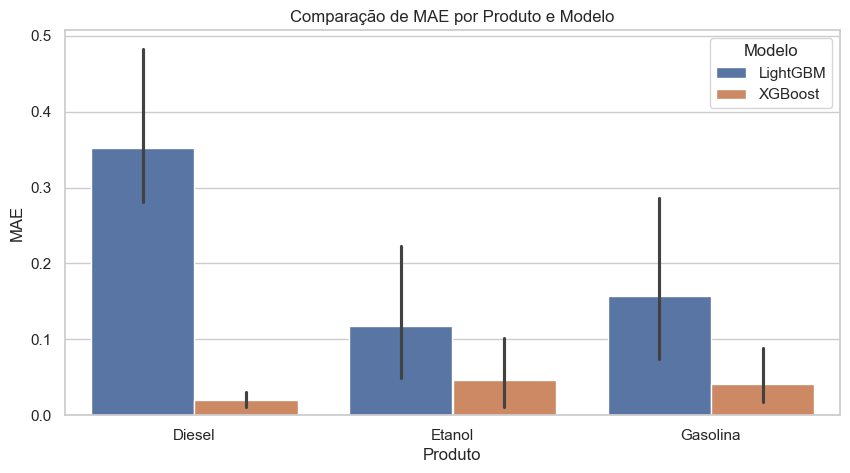

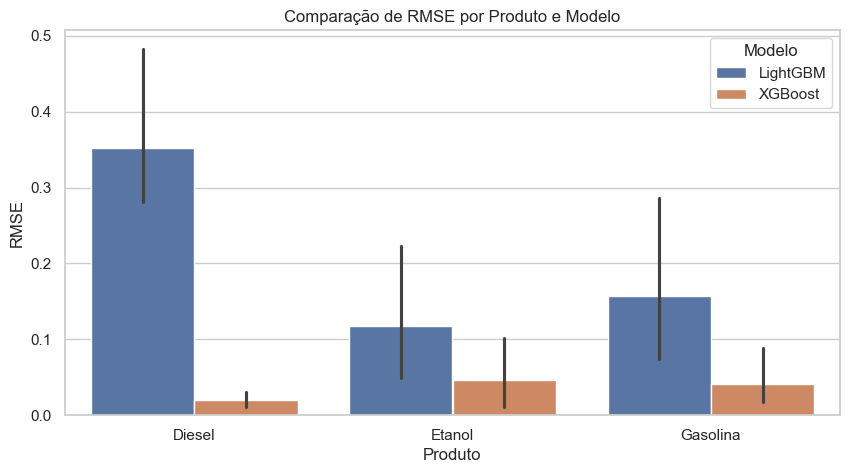

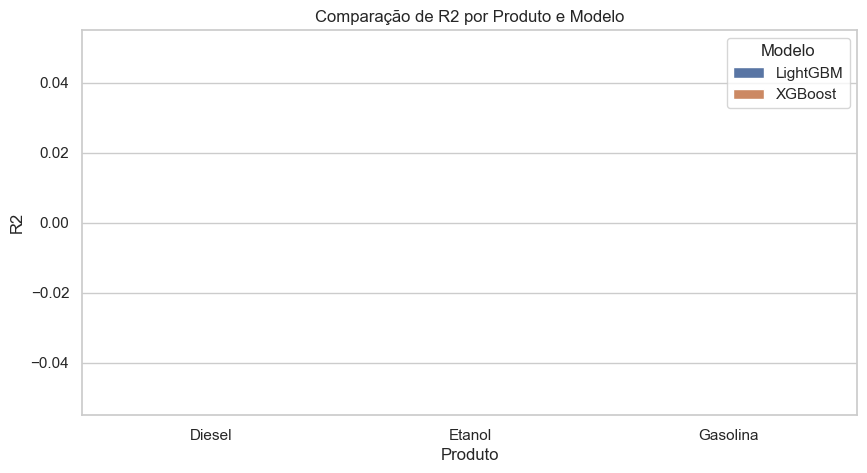

In [10]:

resultados_df = pd.DataFrame(resultados)
display(resultados_df)

sns.set(style="whitegrid")
for metric in ['MAE', 'RMSE', 'R2']:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=resultados_df, x='Produto', y=metric, hue='Modelo')
    plt.title(f'Comparação de {metric} por Produto e Modelo')
    plt.show()


C:\Users\ewotjul\AppData\Local\Temp\ipykernel_16588\2859463321.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resultados_df_prod = resultados_df.query('Modelo == "XGBoost"')[resultados_df["Produto"] == produto]
C:\Users\ewotjul\AppData\Local\Temp\ipykernel_16588\2859463321.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resultados_df_prod = resultados_df.query('Modelo == "XGBoost"')[resultados_df["Produto"] == produto]
C:\Users\ewotjul\AppData\Local\Temp\ipykernel_16588\2859463321.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  resultados_df_prod = resultados_df.query('Modelo == "XGBoost"')[resultados_df["Produto"] == produto]


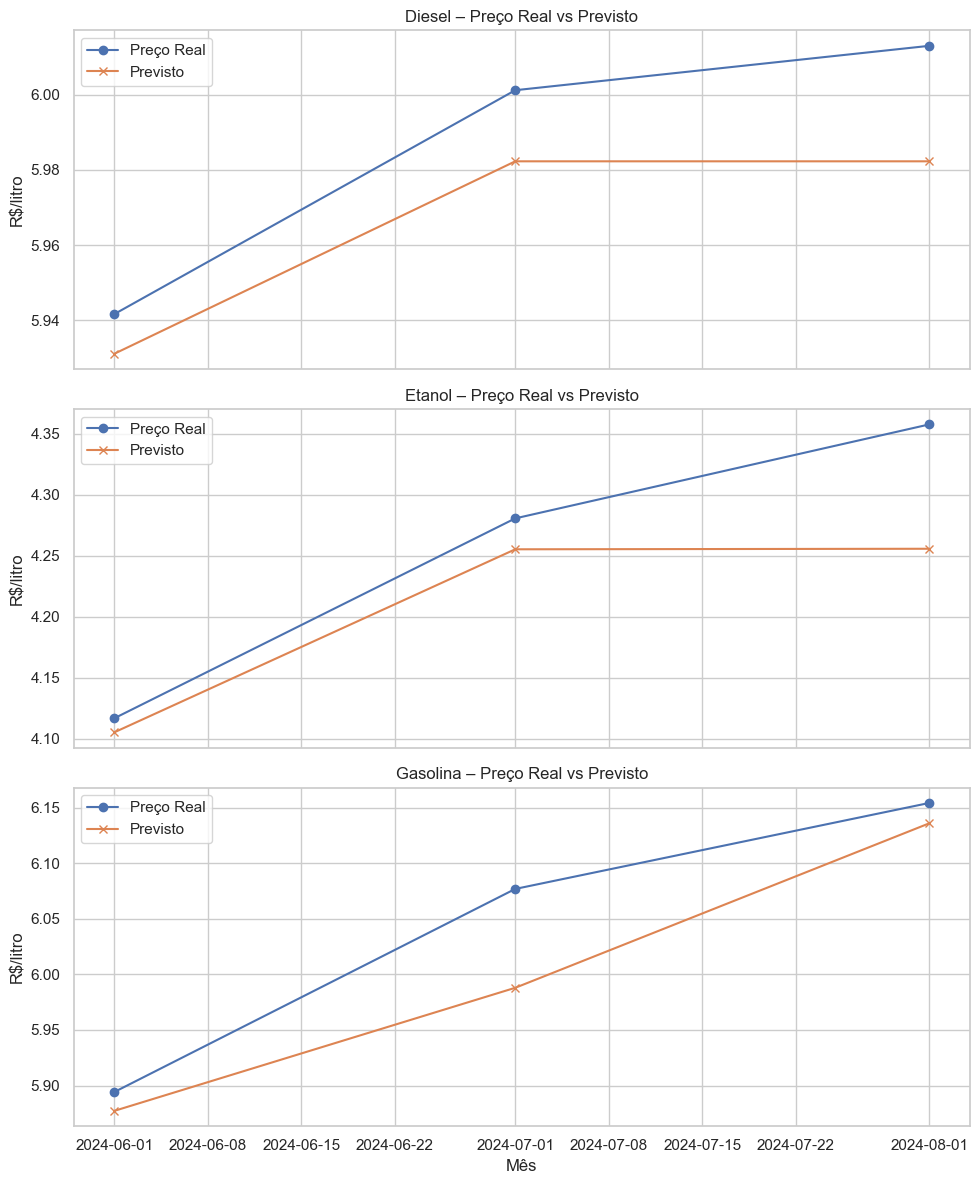

In [12]:
resultados_df["Mês"] = pd.to_datetime(resultados_df["Mês"])

# Lista de produtos
produtos = resultados_df["Produto"].unique()

# Criar os subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

# Loop para cada produto
for i, produto in enumerate(produtos):
    resultados_df_prod = resultados_df.query('Modelo == "XGBoost"')[resultados_df["Produto"] == produto]
    axes[i].plot(resultados_df_prod["Mês"], resultados_df_prod["Real"], label="Preço Real", marker='o')
    axes[i].plot(resultados_df_prod["Mês"], resultados_df_prod["Previsto"], label="Previsto", marker='x')
    axes[i].set_title(f"{produto} – Preço Real vs Previsto")
    axes[i].set_ylabel("R$/litro")
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel("Mês")
plt.tight_layout()
plt.show()